<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

<Ответ>

**Вопрос 2**: Почему бустинг над глубокими деревьями это плохая идея?

<Ответ>

**Вопрос 3**: Что предсказывает каждое дерево (что является признаками а что целевой переменной?)

Задача классификации, следовательно целевая переменная это метка класса (ну или вероятность буть отнесенным к классу). Каждое дерево предсказывает сдвиг к предсказаниям предыдущих деревьев.

<h1 align="center">Binary Boosting Implementation</h1> 

Давайте вспомним бустинг

#### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 

$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

#### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Алгоритм**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - $\hat{y} = \sum_{j=0}^{i-1} a_j b_j(x)$
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$ (Тут дерево не глубокое регрессионное дерево)
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + lr * b_i(x)$
    
    
#### Нужно реализовать двух классовый бустинг с логистической функцией потерь.     

**Функция потерь**:
Я вот думаю, что всем интересно какую-же функцию потерь выбрать $\mathcal{L}(\hat{y},y)=\log\left( 1 + e^{-\hat{y}y} \right)$

тут важный момент есть, даже не один
- $\hat{y}$ -- это ответ композиции, тоесть сумма ответов всех предыдущих деревьев
- Это скалярная функция и производная халява, но вот тут мы вам посчитали $$\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{1}{1 + e^{-y\hat{y}}} \cdot (-ye^{-y\hat{y}})=-y\frac{1}{1 + e^{y\hat{y}}}$$

In [345]:
np.array([1/(1.+np.exp(1)), -1/(1.+np.exp(1)), -1/(1.+np.exp(-1))]).sum()


In [346]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
from scipy.special import expit

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [347]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=3, ):
        self.lr = learning_rate   
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.y_pred = None
        
    @classmethod
    def loss_grad(self, original_y, pred_y):
        # Функция должна вернуть вектор длины = len(pred_y)
        # В каждом элементе вектора должно быть значение градиента dL(pred_y, original_y) / d pred_y[i]
        return -original_y*expit(-original_y*pred_y)# Градиент на каждом объекте
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = [] 
        
        for i in range(self.n_estimators):
            if i==0:
                regr = DecisionTreeRegressor(max_depth=self.max_depth)
                regr.predict = lambda X: np.zeros_like(X.shape[0], dtype=float)
            else:
                grad = self.loss_grad(original_y, self._predict(X))
                # Настройте базовый алгоритм на градиент, это классификация или регрессия?
                regr = DecisionTreeRegressor(max_depth=self.max_depth).fit(X, -grad)
            estimator = deepcopy(regr)
            self.estimators_.append(estimator)

        return self

    
    def _predict(self, X):
        # Эта штука как раз должна вернуть сумму ответов всех алгоритмов 
        # Не забудьте про ленинг рейт
        if self.y_pred is None:
            self.y_pred = np.zeros(X.shape[0], dtype=float)
        self.y_pred += self.lr*self.estimators_[-1].predict(X)
        return self.y_pred
    
    def predict(self, X):
        # А тут на выходе должны быть классы, подумайте как это сделать
        y_pred = np.zeros(X.shape[0])
        for est in self.estimators_:
            y_pred += est.predict(X)
        y_pred = np.sign(y_pred-0.5)
        return y_pred

<h1 align="center">Simple test</h1> 

In [348]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

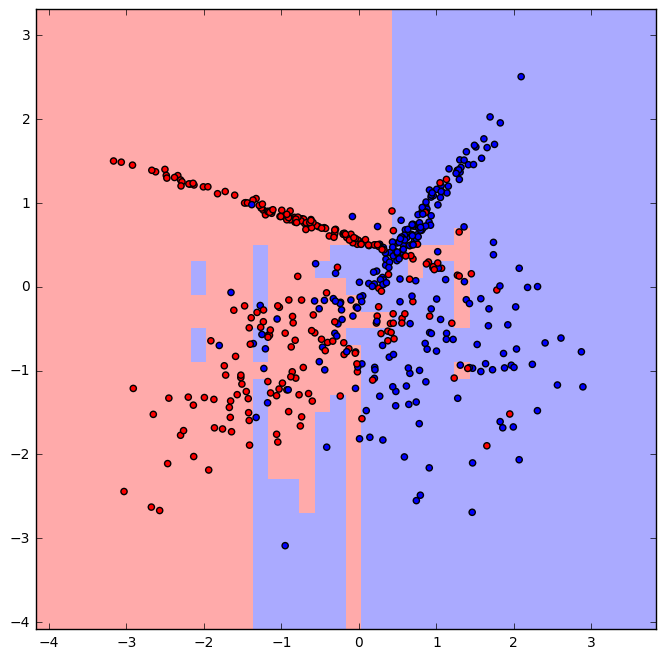

In [349]:
clf = BinaryBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3).fit(X, y)
plot_surface(X, y, clf)
clf.score(X, y)

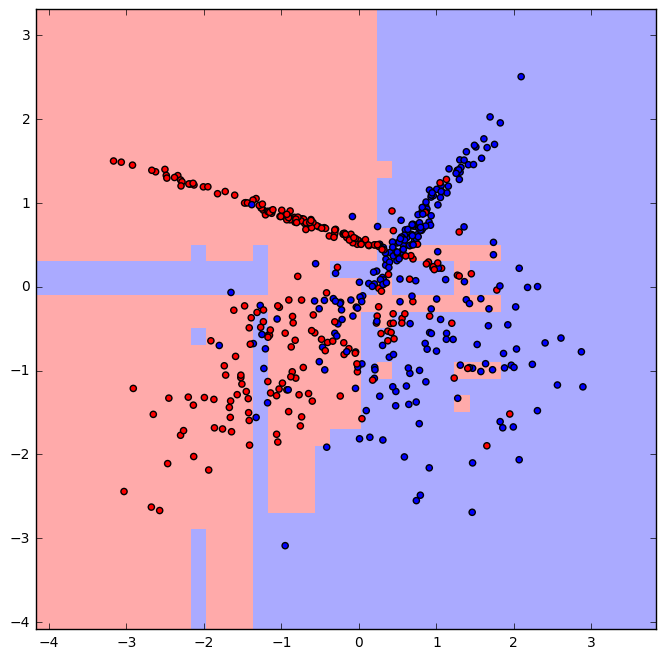

In [350]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0).fit(X, y)
plot_surface(X, y, clf)
clf.score(X, y)

<h1 align="center">Adult test</h1> 

#### Скачайте https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [351]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [352]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [354]:
%%time
clf = BinaryBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3).fit(X, y)
print "BinaryBoostingClassifier", clf.score(X, y)
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0).fit(X, y)
print "GradientBoostingClassifier", clf.score(X, y)

BinaryBoostingClassifier 0.870734928288
GradientBoostingClassifier 0.896440527011
Wall time: 2min 42s


<h1 align="center">Сдача ДЗ</h1> 

Заполните форму https://goo.gl/forms/sPE6gpRDNTOXQai12 
    - Качество вашего алгоритма на adult, один знак после запятой, без округления (0.86 -> 0.8 и тд) точность
    - BinaryBoostingClassifier.loss_grad ([-1, 1, 1], [-1, 1, -1]).sum()

In [355]:
print "Ответ 1:", int(clf.score(X, y)*10)/10.
print "Ответ 2:", BinaryBoostingClassifier.loss_grad(np.array([-1, 1, 1]), np.array([-1, 1, -1])).sum()

Ответ 1: 0.8
Ответ 2: -0.73105857863
